### 卷积神经网络CNN跟学 [PyTorch深度学习：卷积神经网络（CNN）](https://www.bilibili.com/video/BV1vu4y1n77T/?share_source=copy_web&vd_source=43c4eb4ed8da935694eaeb473fd0f6cb)

In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from torchvision import transforms
from torchvision import datasets
import matplotlib.pyplot as plt
# 展示高清图
from matplotlib_inline import backend_inline
backend_inline.set_matplotlib_formats('svg')
import numpy as np
import pandas as pd

#### 一、LeNet-5
LeNet-5 虽诞生于 1998 年，但基于它的手写数字识别系统则非常成功

##### 1. 制作数据集

In [3]:
# 制作数据集
# 数据集转换参数
transform = transforms.Compose([
    transforms.ToTensor(), 
    transforms.Normalize(0.1307, 0.3081)
    ])
# 下载训练集与测试集
train_Data = datasets.MNIST(
    root = 'resoures\dataset', # 下载路径
    train = True, # 是 train 集
    download = True, # 如果该路径没有该数据集，就下载
    transform = transform # 数据集转换参数
    )
test_Data = datasets.MNIST(
    root = 'resoures\dataset', # 下载路径
    train = False, # 是 test 集
    download = True, # 如果该路径没有该数据集，就下载
    transform = transform # 数据集转换参数
    )
# 批次加载器
train_loader = DataLoader(train_Data, shuffle=True, batch_size=256)
test_loader = DataLoader(test_Data, shuffle=False, batch_size=256)

##### 2. 搭建神经网络
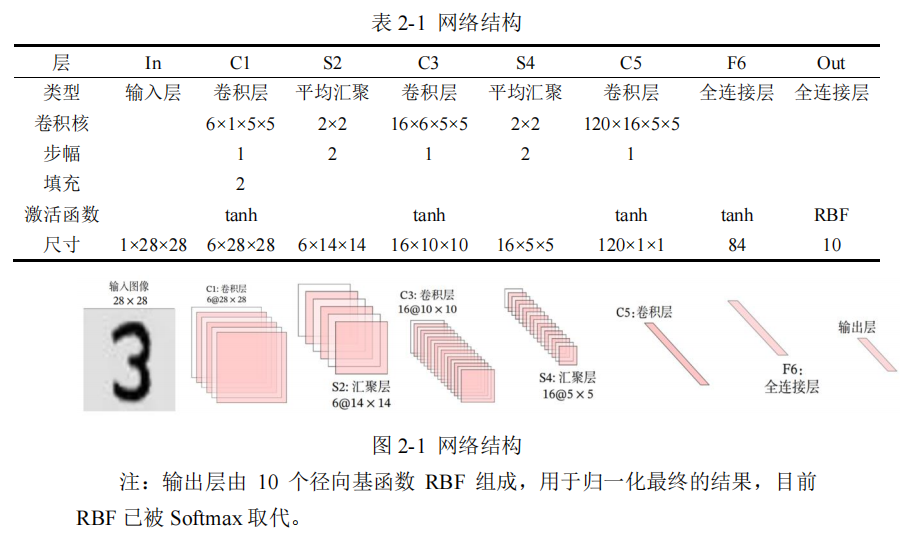  
⚫ in_channel：此层输入图像的通道数；   
⚫ out_channel：此层输出图像的通道数；  
⚫ kernel_size：卷积核尺寸；    
⚫ padding：填充；  
⚫ stride：步幅。

In [4]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN,self).__init__()
        self.net = nn.Sequential(
        nn.Conv2d(1, 6, kernel_size=5, padding=2), nn.Tanh(),
        nn.AvgPool2d(kernel_size=2, stride=2),
        nn.Conv2d(6, 16, kernel_size=5), nn.Tanh(),
        nn.AvgPool2d(kernel_size=2, stride=2),
        nn.Conv2d(16, 120, kernel_size=5), nn.Tanh(),
        nn.Flatten(),
        nn.Linear(120, 84), nn.Tanh(),
        nn.Linear(84, 10)
        )
    def forward(self, x):
        y = self.net(x)
        return y
    
# 查看网络结构
X = torch.rand(size= (1, 1, 28, 28))
for layer in CNN().net:
    X = layer(X)
    print( layer.__class__.__name__, 'output shape: \t', X.shape )
# 创建子类的实例，并搬到 GPU 上
model = CNN().to('cuda:0')

Conv2d output shape: 	 torch.Size([1, 6, 28, 28])
Tanh output shape: 	 torch.Size([1, 6, 28, 28])
AvgPool2d output shape: 	 torch.Size([1, 6, 14, 14])
Conv2d output shape: 	 torch.Size([1, 16, 10, 10])
Tanh output shape: 	 torch.Size([1, 16, 10, 10])
AvgPool2d output shape: 	 torch.Size([1, 16, 5, 5])
Conv2d output shape: 	 torch.Size([1, 120, 1, 1])
Tanh output shape: 	 torch.Size([1, 120, 1, 1])
Flatten output shape: 	 torch.Size([1, 120])
Linear output shape: 	 torch.Size([1, 84])
Tanh output shape: 	 torch.Size([1, 84])
Linear output shape: 	 torch.Size([1, 10])


##### 3. 训练网络

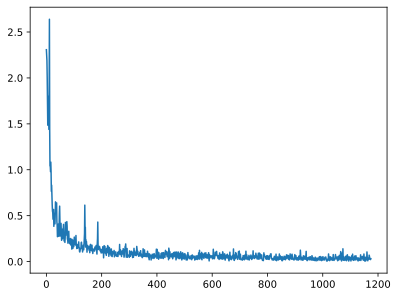

In [5]:
# 损失函数的选择
loss_fn = nn.CrossEntropyLoss() # 自带 softmax 激活函数

# 优化算法的选择
learning_rate = 0.9 # 设置学习率
optimizer = torch.optim.SGD(
    model.parameters(),
    lr = learning_rate,
)

# 训练网络
epochs = 5
losses = [] # 记录损失函数变化的列表
for epoch in range(epochs):
    for (x, y) in train_loader: # 获取小批次的 x 与 y
        x, y = x.to('cuda:0'), y.to('cuda:0')
        Pred = model(x) # 一次前向传播（小批量）
        loss = loss_fn(Pred, y) # 计算损失函数
        losses.append(loss.item()) # 记录损失函数的变化
        optimizer.zero_grad() # 清理上一轮滞留的梯度
        loss.backward() # 一次反向传播
        optimizer.step() # 优化内部参数
Fig = plt.figure()
plt.plot(range(len(losses)), losses)
plt.show()

##### 4. 测试网络

In [6]:
# 测试网络
correct = 0
total = 0
with torch.no_grad(): # 该局部关闭梯度计算功能
    for (x, y) in test_loader: # 获取小批次的 x 与 y
        x, y = x.to('cuda:0'), y.to('cuda:0')
        Pred = model(x) # 一次前向传播（小批量）
        _, predicted = torch.max(Pred.data, dim=1)
        correct += torch.sum( (predicted == y) )
        total += y.size(0) 
print(f'测试集精准度: {100*correct/total} %')

测试集精准度: 98.50999450683594 %


#### 二、AlexNet
AlexNet 是第一个现代深度卷积网络模型，其首次使用了很多现代网络的技术方法，      
作为 2012 年 ImageNet 图像分类竞赛冠军，输入为 3×224×224 的图像，   
输出为 1000 个类别的条件概率

##### 1. 制作数据集

In [7]:
# 数据集转换参数
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize(224),
    transforms.Normalize(0.1307, 0.3081)
    ])
# 下载训练集与测试集
train_Data = datasets.FashionMNIST(
    root = 'resoures\dataset',
    train = True,
    download = True,
    transform = transform
    )
test_Data = datasets.FashionMNIST(
    root = 'resoures\dataset',
    train = False,
    download = True,
    transform = transform
    )
# 批次加载器
train_loader = DataLoader(train_Data, shuffle=True, batch_size=128)
test_loader = DataLoader(test_Data, shuffle=False, batch_size=128)


100%|██████████| 26.4M/26.4M [00:47<00:00, 556kB/s] 


Extracting resoures\dataset\FashionMNIST\raw\train-images-idx3-ubyte.gz to resoures\dataset\FashionMNIST\raw



100%|██████████| 29.5k/29.5k [00:00<00:00, 116kB/s]


Extracting resoures\dataset\FashionMNIST\raw\train-labels-idx1-ubyte.gz to resoures\dataset\FashionMNIST\raw



100%|██████████| 4.42M/4.42M [00:13<00:00, 339kB/s] 


Extracting resoures\dataset\FashionMNIST\raw\t10k-images-idx3-ubyte.gz to resoures\dataset\FashionMNIST\raw



100%|██████████| 5.15k/5.15k [00:00<00:00, 87.7kB/s]

Extracting resoures\dataset\FashionMNIST\raw\t10k-labels-idx1-ubyte.gz to resoures\dataset\FashionMNIST\raw



##### 2. 搭建神经网络

In [8]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN,self).__init__()
        self.net = nn.Sequential(
        nn.Conv2d(1, 96, kernel_size=11, stride=4, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=3, stride=2),
        nn.Conv2d(96, 256, kernel_size=5, padding=2),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=3, stride=2),
        nn.Conv2d(256, 384, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.Conv2d(384, 384, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.Conv2d(384, 256, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=3, stride=2),
        nn.Flatten(),
        nn.Linear(6400, 4096), nn.ReLU(),
        nn.Dropout(p=0.5),
        nn.Linear(4096, 4096), nn.ReLU(),
        nn.Dropout(p=0.5),
        nn.Linear(4096, 10)
        )
    def forward(self, x):
        y = self.net(x)
        return y
    
    # 查看网络结构
X = torch.rand(size= (1, 1, 224, 224))
for layer in CNN().net:
    X = layer(X)
    print( layer.__class__.__name__, 'output shape: \t', X.shape )
model = CNN().to('cuda:0')

Conv2d output shape: 	 torch.Size([1, 96, 54, 54])
ReLU output shape: 	 torch.Size([1, 96, 54, 54])
MaxPool2d output shape: 	 torch.Size([1, 96, 26, 26])
Conv2d output shape: 	 torch.Size([1, 256, 26, 26])
ReLU output shape: 	 torch.Size([1, 256, 26, 26])
MaxPool2d output shape: 	 torch.Size([1, 256, 12, 12])
Conv2d output shape: 	 torch.Size([1, 384, 12, 12])
ReLU output shape: 	 torch.Size([1, 384, 12, 12])
Conv2d output shape: 	 torch.Size([1, 384, 12, 12])
ReLU output shape: 	 torch.Size([1, 384, 12, 12])
Conv2d output shape: 	 torch.Size([1, 256, 12, 12])
ReLU output shape: 	 torch.Size([1, 256, 12, 12])
MaxPool2d output shape: 	 torch.Size([1, 256, 5, 5])
Flatten output shape: 	 torch.Size([1, 6400])
Linear output shape: 	 torch.Size([1, 4096])
ReLU output shape: 	 torch.Size([1, 4096])
Dropout output shape: 	 torch.Size([1, 4096])
Linear output shape: 	 torch.Size([1, 4096])
ReLU output shape: 	 torch.Size([1, 4096])
Dropout output shape: 	 torch.Size([1, 4096])
Linear output sh

##### 3. 训练网络

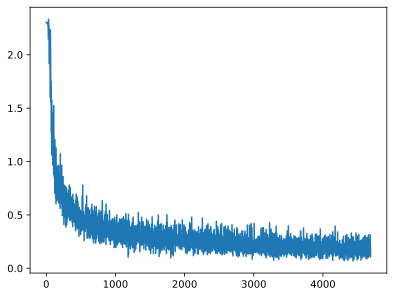

In [9]:
# 损失函数的选择
loss_fn = nn.CrossEntropyLoss() # 自带 softmax 激活函数
# 优化算法的选择
learning_rate = 0.1 # 设置学习率
optimizer = torch.optim.SGD(
    model.parameters(),
    lr = learning_rate,
)
# 训练网络
epochs = 10
losses = [] # 记录损失函数变化的列表
for epoch in range(epochs):
    for (x, y) in train_loader: # 获取小批次的 x 与 y
        x, y = x.to('cuda:0'), y.to('cuda:0')
        Pred = model(x) # 一次前向传播（小批量）
        loss = loss_fn(Pred, y) # 计算损失函数
        losses.append(loss.item()) # 记录损失函数的变化
        optimizer.zero_grad() # 清理上一轮滞留的梯度
        loss.backward() # 一次反向传播
        optimizer.step() # 优化内部参数
Fig = plt.figure()
plt.plot(range(len(losses)), losses)
plt.show()

##### 4. 测试网络

In [10]:
# 测试网络
correct = 0
total = 0
with torch.no_grad(): # 该局部关闭梯度计算功能
    for (x, y) in test_loader: # 获取小批次的 x 与 y
        x, y = x.to('cuda:0'), y.to('cuda:0')
        Pred = model(x) # 一次前向传播（小批量）
        _, predicted = torch.max(Pred.data, dim=1)
        correct += torch.sum( (predicted == y) )
        total += y.size(0)
print(f'测试集精准度: {100*correct/total} %')

测试集精准度: 91.3499984741211 %


#### 三、GoogLeNet
2014 年，获得 ImageNet 图像分类竞赛的冠军是 GoogLeNet，其解决了一个重要问题：滤波器超参数选择困难，如何能够自动找到最佳的情况。     
其在网络中引入了一个小网络——Inception 块，由 4 条并行路径组成，4 条路径互不干扰。   
这样一来，超参数最好的分支的那条分支，其权重会在训练过程中不断增加，这就类似于帮我们挑选最佳的超参数

##### 1. 制作数据集

In [11]:
# 数据集转换参数
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(0.1307, 0.3081)
])
# 下载训练集与测试集
train_Data = datasets.FashionMNIST(
    root = 'resoures\dataset',
    train = True,
    download = True,
    transform = transform
)
test_Data = datasets.FashionMNIST(
    root = 'resoures\dataset',
    train = False,
    download = True,
    transform = transform
)
# 批次加载器
train_loader = DataLoader(train_Data, shuffle=True, batch_size=128)
test_loader = DataLoader(test_Data, shuffle=False, batch_size=128)

##### 2. 搭建网络

In [12]:
# 一个 Inception 块
class Inception(nn.Module):
    def __init__(self, in_channels):
        super(Inception, self).__init__()
        self.branch1 = nn.Conv2d(in_channels, 16, kernel_size=1)
        self.branch2 = nn.Sequential(
        nn.Conv2d(in_channels, 16, kernel_size=1),
        nn.Conv2d(16, 24, kernel_size=3, padding=1),
        nn.Conv2d(24, 24, kernel_size=3, padding=1)
        )
        self.branch3 = nn.Sequential(
        nn.Conv2d(in_channels, 16, kernel_size=1),
        nn.Conv2d(16, 24, kernel_size=5, padding=2)
        )
        self.branch4 = nn.Conv2d(in_channels, 24, kernel_size=1)
    def forward(self, x):
        branch1 = self.branch1(x)
        branch2 = self.branch2(x)
        branch3 = self.branch3(x)
        branch4 = self.branch4(x)
        outputs = [branch1, branch2, branch3, branch4]
        return torch.cat(outputs, 1)

In [13]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.net = nn.Sequential(
        nn.Conv2d(1, 10, kernel_size=5), nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),
        Inception(in_channels=10),
        nn.Conv2d(88, 20, kernel_size=5), nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),
        Inception(in_channels=20),
        nn.Flatten(),
        nn.Linear(1408, 10)
        )
    
    def forward(self, x):
        y = self.net(x) 
        return y

# 查看网络结构
X = torch.rand(size= (1, 1, 28, 28))
for layer in CNN().net:
    X = layer(X)
    print( layer.__class__.__name__, 'output shape: \t', X.shape )

# 创建子类的实例，并搬到 GPU 上
model = CNN().to('cuda:0')

Conv2d output shape: 	 torch.Size([1, 10, 24, 24])
ReLU output shape: 	 torch.Size([1, 10, 24, 24])
MaxPool2d output shape: 	 torch.Size([1, 10, 12, 12])
Inception output shape: 	 torch.Size([1, 88, 12, 12])
Conv2d output shape: 	 torch.Size([1, 20, 8, 8])
ReLU output shape: 	 torch.Size([1, 20, 8, 8])
MaxPool2d output shape: 	 torch.Size([1, 20, 4, 4])
Inception output shape: 	 torch.Size([1, 88, 4, 4])
Flatten output shape: 	 torch.Size([1, 1408])
Linear output shape: 	 torch.Size([1, 10])


##### 3. 训练网络

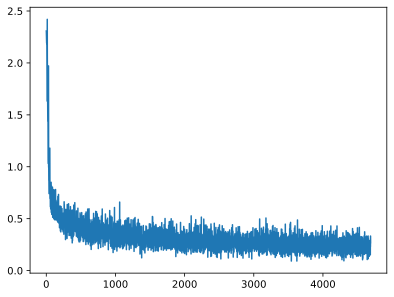

In [14]:
# 损失函数的选择
loss_fn = nn.CrossEntropyLoss()
# 优化算法的选择
learning_rate = 0.1 # 设置学习率
optimizer = torch.optim.SGD(
    model.parameters(),
    lr = learning_rate,
)
# 训练网络
epochs = 10
losses = [] # 记录损失函数变化的列表
for epoch in range(epochs):
    for (x, y) in train_loader: # 获取小批次的 x 与 y
        x, y = x.to('cuda:0'), y.to('cuda:0')
        Pred = model(x) # 一次前向传播（小批量）
        loss = loss_fn(Pred, y) # 计算损失函数
        losses.append(loss.item()) # 记录损失函数的变化
        optimizer.zero_grad() # 清理上一轮滞留的梯度
        loss.backward() # 一次反向传播
        optimizer.step() # 优化内部参数
Fig = plt.figure()
plt.plot(range(len(losses)), losses)
plt.show()

##### 4. 测试网络

In [15]:
# 测试网络
correct = 0
total = 0
with torch.no_grad(): # 该局部关闭梯度计算功能
    for (x, y) in test_loader: # 获取小批次的 x 与 y
        x, y = x.to('cuda:0'), y.to('cuda:0')
        Pred = model(x) # 一次前向传播（小批量）
        _, predicted = torch.max(Pred.data, dim=1)
        correct += torch.sum( (predicted == y) )
        total += y.size(0)
print(f'测试集精准度: {100*correct/total} %')

测试集精准度: 89.47000122070312 %


#### 四、ResNet
残差网络（Residual Network，ResNet）荣获 2015 年的 ImageNet 图像分类竞赛冠军，  
其可以缓解深度神经网络中增加深度带来的“梯度消失”问题。在反向传播计算梯度时，梯度是不断相乘的，  
假如训练到后期，各层的梯度均小于 1，则其相乘起来就会不断趋于 0。    
因此，深度学习的隐藏层并非越多越好，隐藏层越深，梯度越趋于 0，此之谓“梯度消失”。    
而残差块将某模块的输入 x 引到输出 y 处，使原本的梯度不会消失    
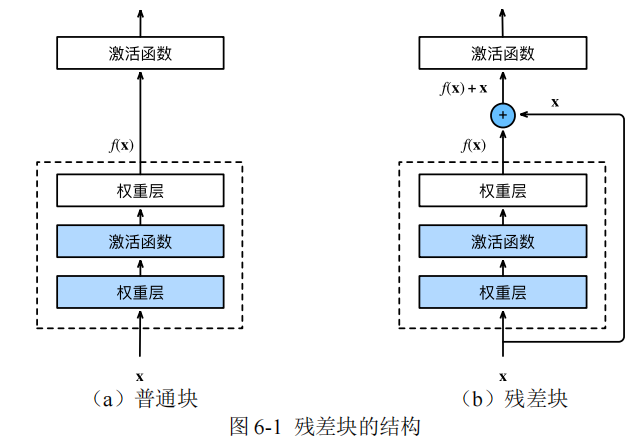

##### 1. 制作数据集

In [16]:
# 数据集转换参数
transform = transforms.Compose([transforms.ToTensor(),
    transforms.Normalize(0.1307, 0.3081)
])
# 下载训练集与测试集
train_Data = datasets.FashionMNIST(
    root = 'resoures\dataset',
    train = True,
    download = True,
    transform = transform
)
test_Data = datasets.FashionMNIST(
    root = 'resoures\dataset',
    train = False,
    download = True,
    transform = transform
    )

# 批次加载器
train_loader = DataLoader(train_Data, shuffle=True, batch_size=128)
test_loader = DataLoader(test_Data, shuffle=False, batch_size=128)

##### 2. 搭建残差神经网络

In [17]:
# 残差块
class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super(ResidualBlock, self).__init__()
        self.net = nn.Sequential(
        nn.Conv2d(channels, channels, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.Conv2d(channels, channels, kernel_size=3, padding=1),
        )
    def forward(self, x):
        y = self.net(x)
        return nn.functional.relu(x+y)

In [18]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.net = nn.Sequential(
        nn.Conv2d(1, 16, kernel_size=5), nn.ReLU(),
        nn.MaxPool2d(2), ResidualBlock(16),
        nn.Conv2d(16, 32, kernel_size=5), nn.ReLU(),
        nn.MaxPool2d(2), ResidualBlock(32),
        nn.Flatten(),
        nn.Linear(512, 10)
        )
    def forward(self, x):
        y = self.net(x) 
        return y

In [19]:
# 查看网络结构
X = torch.rand(size= (1, 1, 28, 28))
for layer in CNN().net:
    X = layer(X)
    print( layer.__class__.__name__, 'output shape: \t', X.shape )

# 创建子类的实例，并搬到 GPU 上
model = CNN().to('cuda:0')

Conv2d output shape: 	 torch.Size([1, 16, 24, 24])
ReLU output shape: 	 torch.Size([1, 16, 24, 24])
MaxPool2d output shape: 	 torch.Size([1, 16, 12, 12])
ResidualBlock output shape: 	 torch.Size([1, 16, 12, 12])
Conv2d output shape: 	 torch.Size([1, 32, 8, 8])
ReLU output shape: 	 torch.Size([1, 32, 8, 8])
MaxPool2d output shape: 	 torch.Size([1, 32, 4, 4])
ResidualBlock output shape: 	 torch.Size([1, 32, 4, 4])
Flatten output shape: 	 torch.Size([1, 512])
Linear output shape: 	 torch.Size([1, 10])


##### 3. 训练网络

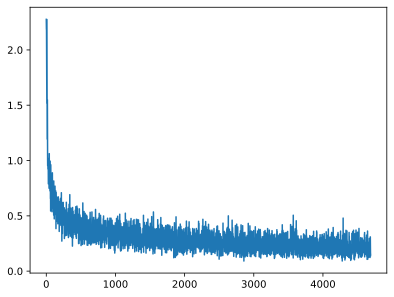

In [20]:
# 损失函数的选择
loss_fn = nn.CrossEntropyLoss()
# 优化算法的选择
learning_rate = 0.1 # 设置学习率
optimizer = torch.optim.SGD(
 model.parameters(),
 lr = learning_rate,
)
# 训练网络
epochs = 10
losses = [] # 记录损失函数变化的列表
for epoch in range(epochs):
    for (x, y) in train_loader: # 获取小批次的 x 与 y
        x, y = x.to('cuda:0'), y.to('cuda:0')
        Pred = model(x) # 一次前向传播（小批量）
        loss = loss_fn(Pred, y) # 计算损失函数
        losses.append(loss.item()) # 记录损失函数的变化
        optimizer.zero_grad() # 清理上一轮滞留的梯度
        loss.backward() # 一次反向传播
        optimizer.step() # 优化内部参数
Fig = plt.figure()
plt.plot(range(len(losses)), losses)
plt.show()

##### 4. 测试网络

In [21]:
correct = 0
total = 0
with torch.no_grad(): # 该局部关闭梯度计算功能
    for (x, y) in test_loader: # 获取小批次的 x 与 y
        x, y = x.to('cuda:0'), y.to('cuda:0')
        Pred = model(x) # 一次前向传播（小批量）
        _, predicted = torch.max(Pred.data, dim=1)
        correct += torch.sum( (predicted == y) )
        total += y.size(0)
print(f'测试集精准度: {100*correct/total} %')

测试集精准度: 89.81999969482422 %
